
# Training an FNO on Darcy-Flow

We train a Fourier Neural Operator (FNO) on our small `Darcy-Flow example <sphx_glr_auto_examples_data_plot_darcy_flow.py>`.

This tutorial demonstrates the complete workflow of training a neural operator:
1. Loading and preprocessing the Darcy-Flow dataset
2. Creating an FNO model architecture
3. Setting up training components (optimizer, scheduler, losses)
4. Training the model
5. Evaluating predictions and zero-shot super-resolution

Note that this dataset is much smaller than one we would use in practice. The small Darcy-flow is an example built to
be trained on a CPU in a few seconds, whereas normally we would train on one or multiple GPUs.

The FNO's key advantage is its resolution invariance - it can make predictions at different resolutions
without retraining, which we will demonstrate in the zero-shot super-resolution section.


.. raw:: html

   <div style="margin-top: 3em;"></div>

## Import dependencies
We import the necessary modules from `neuralop` for training a Fourier Neural Operator



In [ ]:
!pip install neuraloperator -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 63.0 MB/s eta 0:00:00


In [ ]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = "cuda"

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Loading the Darcy-Flow dataset
We load the small Darcy-Flow dataset with multiple resolutions for training and testing.
The dataset contains permeability fields (input) and pressure fields (output).



In [ ]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=1,
    batch_size=64,
    n_tests=[5, 5],
    test_resolutions=[64, 128],
    test_batch_sizes=[32, 32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 64 with 5 samples 
Loading test db for resolution 128 with 5 samples 


.. raw:: html

   <div style="margin-top: 3em;"></div>

## Creating the FNO model



In [ ]:
model = FNO(
    n_modes=(16, 16),
    in_channels=1,
    out_channels=1,
    hidden_channels=48,
    projection_channel_ratio=2,
)
model_path = '/content/high_checkpoints/model_state_dict.pt'
model.load_state_dict(torch.load(model_path, map_location=device , weights_only = False))
model = model.to(device)

# Count and display the number of parameters
n_params = count_model_params(model)
print(f"\nOur model has {n_params} parameters.")
sys.stdout.flush()


Our model has 2683153 parameters.


.. raw:: html

   <div style="margin-top: 3em;"></div>

## Creating the optimizer and scheduler
We use AdamW optimizer with weight decay for regularization



In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Setting up loss functions
We use H1 loss for training and L2 loss for evaluation
H1 loss is particularly good for PDE problems as it penalizes both function values and gradients



In [ ]:
l2loss = LpLoss(d=2, p=2)  # L2 loss for function values
h1loss = H1Loss(d=2)  # H1 loss includes gradient information

train_loss = h1loss
eval_losses = {"h1": h1loss, "l2": l2loss}

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Training the model
We display the training configuration and then train the model



In [ ]:
print("\n### MODEL ###\n", model)
print("\n### OPTIMIZER ###\n", optimizer)
print("\n### SCHEDULER ###\n", scheduler)
print("\n### LOSSES ###")
print(f"\n * Train: {train_loss}")
print(f"\n * Test: {eval_losses}")
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([48, 48, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(48, 48, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(48, 24, kernel_size=(1,), stride=(1,))
          (1): Conv1d(24, 48, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 96, kernel_size=(1,), stride=(1,))
      (1): Conv1d(96, 48, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(48, 96, kernel_size=(1,), stride=(1,))
      (1): Conv1d(96, 

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Creating the trainer
We create a Trainer object that handles the training loop, evaluation, and logging



In [ ]:
trainer = Trainer(
    model=model,
    n_epochs=50,
    device=device,
    data_processor=data_processor,
    wandb_log=False,  # Disable Weights & Biases logging for this tutorial
    eval_interval=5,  # Evaluate every 5 epochs
    use_distributed=False,  # Single GPU/CPU training
    verbose=True,  # Print training progress
)

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Training the model
We train the model on our Darcy-Flow dataset. The trainer will:
1. Run the forward pass through the FNO
2. Compute the H1 loss
3. Backpropagate and update weights
4. Evaluate on test data every 3 epochs



In [ ]:
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=5,
    save_dir="./high_checkpoints",
)

Training on 1000 samples
Testing on [500, 500] samples         on resolutions [64, 128].


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1784: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)


Raw outputs of shape torch.Size([64, 1, 16, 16])


/usr/local/lib/python3.12/dist-packages/neuralop/training/trainer.py:536: UserWarning: H1Loss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


[0] time=6.73, avg_loss=0.9774, train_err=61.0881


/usr/local/lib/python3.12/dist-packages/neuralop/training/trainer.py:581: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  val_loss = loss(out, **sample)


Eval: 64_h1=1.0078, 64_l2=0.5719, 128_h1=1.1408, 128_l2=0.5717
[Rank 0]: saved training state to ./high_checkpoints
[5] time=6.95, avg_loss=0.3280, train_err=20.5031
Eval: 64_h1=0.8436, 64_l2=0.2562, 128_h1=1.1046, 128_l2=0.2653
[Rank 0]: saved training state to ./high_checkpoints
[10] time=7.61, avg_loss=0.2259, train_err=14.1157
Eval: 64_h1=0.8787, 64_l2=0.2166, 128_h1=1.1518, 128_l2=0.2285
[Rank 0]: saved training state to ./high_checkpoints
[15] time=6.91, avg_loss=0.2038, train_err=12.7403
Eval: 64_h1=0.8902, 64_l2=0.2075, 128_h1=1.1750, 128_l2=0.2200
[Rank 0]: saved training state to ./high_checkpoints
[20] time=6.80, avg_loss=0.1923, train_err=12.0203
Eval: 64_h1=0.8983, 64_l2=0.2011, 128_h1=1.1866, 128_l2=0.2134
[Rank 0]: saved training state to ./high_checkpoints
[25] time=6.24, avg_loss=0.1869, train_err=11.6811
Eval: 64_h1=0.9151, 64_l2=0.2006, 128_h1=1.2129, 128_l2=0.2130
[Rank 0]: saved training state to ./high_checkpoints
[30] time=6.42, avg_loss=0.1854, train_err=11.5905

{'train_err': 10.362809419631958,
 'avg_loss': 0.16580495071411133,
 'avg_lasso_loss': None,
 'epoch_train_time': 6.86444597100035}

.. raw:: html

   <div style="margin-top: 3em;"></div>

Visualizing predictions
------------------------
Let's take a look at what our model's predicted outputs look like.
We wll compare the inputs, ground-truth outputs, and model predictions side by side.

Note that in this example, we train on a very small resolution for
a very small number of epochs. In practice, we would train at a larger
resolution on many more samples.



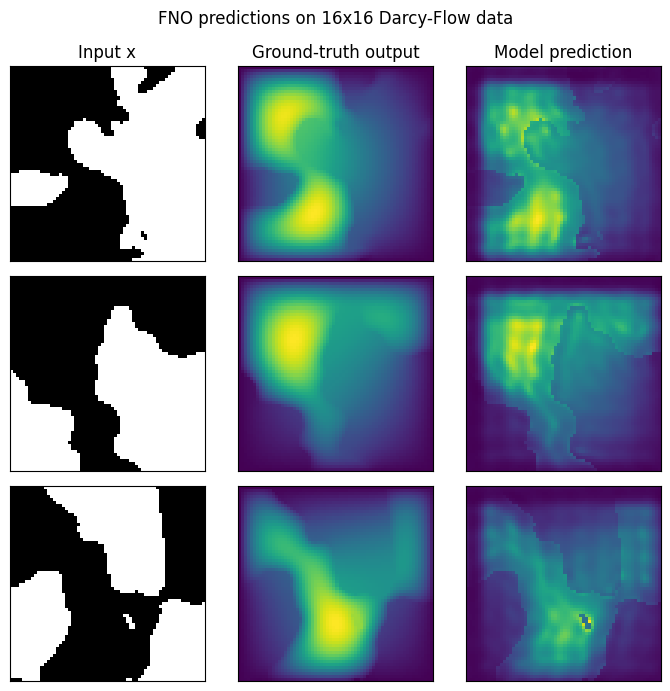

In [ ]:
test_samples = test_loaders[64].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    # Input
    x = data["x"]
    # Ground-truth output
    y = data["y"]
    # Model prediction
    out = model(x.unsqueeze(0))

    # Plot input
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    ax.imshow(x[0], cmap="gray")
    if index == 0:
        ax.set_title("Input x")
    plt.xticks([], [])
    plt.yticks([], [])

    # Plot ground-truth output
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("Ground-truth output")
    plt.xticks([], [])
    plt.yticks([], [])

    # Plot model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title("Model prediction")
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle("FNO predictions on 16x16 Darcy-Flow data", y=0.98)
plt.tight_layout()
fig.show()

.. raw:: html

   <div style="margin-top: 3em;"></div>

.. zero_shot :
Zero-shot super-resolution evaluation
-------------------------------------
One of the key advantages of neural operators is their resolution invariance.
The FNO's invariance to the discretization of input data means we can natively
make predictions on higher-resolution inputs and get higher-resolution outputs
without retraining the model!



In [ ]:
test_samples = test_loaders[128].dataset

In [ ]:
len(test_samples)

5

In [ ]:
t1 = torch.stack([test_samples[0]['x'] , test_samples[1]['x']] , dim=0)
save_path = r"/content/t1_darcy.pt"
torch.save(t1 , save_path)

In [ ]:
t2 = torch.stack([test_samples[2]['x'] , test_samples[3]['x']] , dim=0)
save_path = r"/content/t2_darcy.pt"
torch.save(t2 , save_path)

In [ ]:
import torch
import os

# Example: directory where you want to save tensors
save_dir = r"/content/darcy_test_tensors"

# Create directory if it doesn’t exist
os.makedirs(save_dir, exist_ok=True)

# How many samples to save
num_samples = 50

# Ensure we don’t exceed available samples
num_samples = min(num_samples, len(test_samples))

# Loop through and save tensors
for i in range(num_samples):
    sample = test_samples[i]
    x_tensor = sample["x"]
    y_tensor = sample["y"]

    # Define paths
    x_path = os.path.join(save_dir, f"x_{i:03d}.pt")
    y_path = os.path.join(save_dir, f"y_{i:03d}.pt")

    # Save tensors
    torch.save(x_tensor, x_path)
    torch.save(y_tensor, y_path)

print(f"✅ Saved {num_samples} x/y tensor pairs in: {save_dir}")


✅ Saved 5 x/y tensor pairs in: /content/darcy_test_tensors


In [ ]:
import shutil
import os

# --- USER CONFIG ---
folder_path = r"/content/darcy_test_tensors"
zip_path = r"/content/darcy_test_tensors1"

# --- CREATE ZIP FILE ---
# shutil.make_archive(base_name, format, root_dir)
shutil.make_archive(zip_path, 'zip', folder_path)

print(f"✅ Folder zipped successfully: {zip_path}.zip")


✅ Folder zipped successfully: /content/darcy_test_tensors1.zip


In [ ]:
from google.colab import files

files.download("/content/darcy_test_tensors1.zip")  # replace with your file path


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

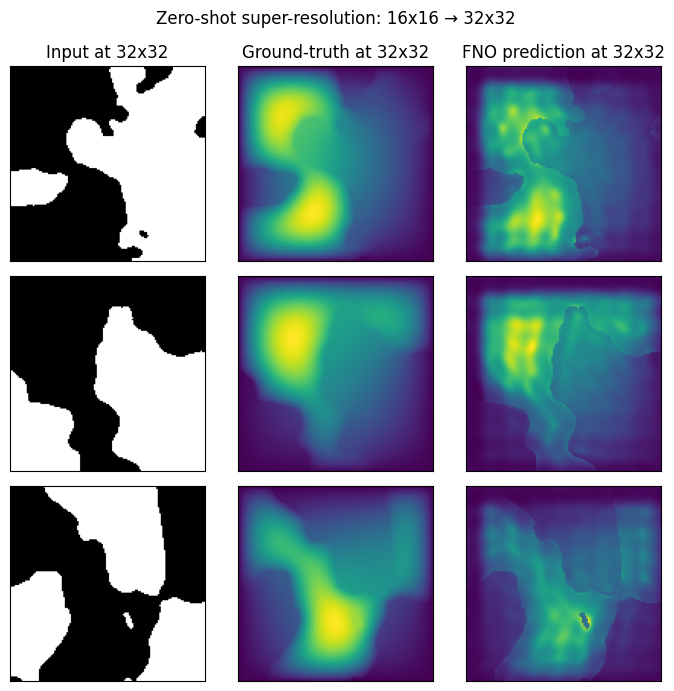

In [ ]:
test_samples = test_loaders[128].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    # Input at higher-resolution
    x = data["x"]
    # Ground-truth output at higher-resolution
    y = data["y"]
    # Model prediction at higher-resolution
    out = model(x.unsqueeze(0))

    # Plot input at higher-resolution
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    ax.imshow(x[0], cmap="gray")
    if index == 0:
        ax.set_title("Input at 32x32")
    plt.xticks([], [])
    plt.yticks([], [])

    # Plot ground-truth output at higher-resolution
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("Ground-truth at 32x32")
    plt.xticks([], [])
    plt.yticks([], [])

    # Plot model prediction at higher-resolution
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title("FNO prediction at 32x32")
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle("Zero-shot super-resolution: 16x16 → 32x32", y=0.98)
plt.tight_layout()
fig.show()

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Understanding zero-shot super-resolution
We only trained the model on data at a resolution of 16x16, and with no modifications
or special prompting, we were able to perform inference on higher-resolution input data
and get higher-resolution predictions! This is a powerful capability of neural operators.

In practice, we often want to evaluate neural operators at multiple resolutions to track
a model's zero-shot super-resolution performance throughout training. That's why many of
our datasets, including the small Darcy-flow we showcased, are parameterized with a list
of `test_resolutions` to choose from.

Note: These predictions may be noisier than we would expect for a model evaluated
at the same resolution at which it was trained. This is because the model hasn't seen
the higher-frequency patterns present in the 32x32 data during training. However, this
demonstrates the fundamental resolution invariance of neural operators.

